In [14]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats
import shap
import seaborn as sns

def SHAP(bst, X_train_df):
    # SHAP値を計算
    explainer = shap.TreeExplainer(bst)
    shap_values = explainer.shap_values(X_train_df)
    
    # SHAP値をプロット
    shap.summary_plot(shap_values, X_train_df, max_display=X_train_df.shape[1])
    return shap_values

def BFI(bst):
    # ビルトインのフィーチャーインポータンスを取得
    feature_importances = bst.get_score(importance_type='weight')

    # 特徴量の名前とインポータンスをプリント
    for key, value in feature_importances.items():
        print(f"Feature: {key}, Importance: {value}")

    # フィーチャーインポータンスをプロット
    xgb.plot_importance(bst)
    plt.show()
    return

def XGBoost(X, y):
    # データを訓練用とテスト用に分割
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # 訓練データをさらに訓練用と検証用に分割
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

    # モデルのパラメータを設定(CPU)
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.1,
        'max_depth': 4,
        'seed': 0
    }
    
    """   # モデルのパラメータを設定(GPU)
    params = {
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        'num_class' : 4,
        'eta': 0.1,
        'max_depth': 12,
        'seed': 0,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }"""

    # データをpandas.DataFrame形式で保存
    X_train_df = pd.DataFrame(X_train, columns=column_names)

    # 訓練データと検証データをXGBoostのDMatrix形式に変換
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # 訓練データと検証データのセットをリストに格納
    evals = [(dtrain, 'train'), (dval, 'eval')]

    # モデルを訓練
    bst = xgb.train(params, dtrain, num_boost_round=10000, evals=evals, early_stopping_rounds=100)

    # テストデータをDMatrix形式に変換
    dtest = xgb.DMatrix(X_test)

    # 訓練データで予測
    y_train_pred = bst.predict(dtrain)

    # テストデータで予測
    y_pred = bst.predict(dtest)

    # 評価
    train_accuracy = accuracy_score(y_train, y_train_pred.round())
    print(f"Training Accuracy: {train_accuracy*100:.2f}%")

    # 評価
    test_accuracy = accuracy_score(y_test, y_pred.round())
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")

    #SHAP(bst, X_train_df)
    # SHAP値を計算
    explainer = shap.TreeExplainer(bst)
    shap_values = explainer.shap_values(X_train_df)
    
    # SHAP値をプロット
    shap.summary_plot(shap_values, X_train_df, max_display=X_train_df.shape[1])
    
    #BFI(bst)
    return shap_values, y_train_pred, X_train_df

def normalize_per_state(df, start, end):
    scaler = StandardScaler()
    df.iloc[start:end, :] = scaler.fit_transform(df.iloc[start:end, :])
    return df


In [15]:
raw = 1 #rawデータならば１、Bandなら０,

# 1秒ごとのデータに分割
n_samples_per_second = 256  # 256Hzのサンプリングレート
total_seconds = 10  # 全体の秒数

# データの読み込み
if(raw):
    df = pd.read_csv('Raw.csv')
    #df = pd.read_csv('Raw_ICA.csv')
else:
    df = pd.read_csv('Band.csv')
    #df = pd.read_csv('emotion.csv')


# チャンネルごとに正規化
scaler = StandardScaler()
for column in df.columns[:-1]:  # 'State'列を除くすべての列
    df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))


[0]	train-logloss:0.62850	eval-logloss:0.63292
[1]	train-logloss:0.57508	eval-logloss:0.58239
[2]	train-logloss:0.53031	eval-logloss:0.54208
[3]	train-logloss:0.48395	eval-logloss:0.49864
[4]	train-logloss:0.44442	eval-logloss:0.46273
[5]	train-logloss:0.40997	eval-logloss:0.43131
[6]	train-logloss:0.38412	eval-logloss:0.40834
[7]	train-logloss:0.35986	eval-logloss:0.38571
[8]	train-logloss:0.33873	eval-logloss:0.36610
[9]	train-logloss:0.31687	eval-logloss:0.34584
[10]	train-logloss:0.30015	eval-logloss:0.33133
[11]	train-logloss:0.28275	eval-logloss:0.31503
[12]	train-logloss:0.26697	eval-logloss:0.30085
[13]	train-logloss:0.25341	eval-logloss:0.28758
[14]	train-logloss:0.23995	eval-logloss:0.27502
[15]	train-logloss:0.22888	eval-logloss:0.26438
[16]	train-logloss:0.21827	eval-logloss:0.25486
[17]	train-logloss:0.20978	eval-logloss:0.24769
[18]	train-logloss:0.19905	eval-logloss:0.23706
[19]	train-logloss:0.18974	eval-logloss:0.22711
[20]	train-logloss:0.18152	eval-logloss:0.21995
[2

[170]	train-logloss:0.00646	eval-logloss:0.03544
[171]	train-logloss:0.00640	eval-logloss:0.03525
[172]	train-logloss:0.00636	eval-logloss:0.03502
[173]	train-logloss:0.00631	eval-logloss:0.03491
[174]	train-logloss:0.00626	eval-logloss:0.03469
[175]	train-logloss:0.00621	eval-logloss:0.03456
[176]	train-logloss:0.00616	eval-logloss:0.03459
[177]	train-logloss:0.00611	eval-logloss:0.03474
[178]	train-logloss:0.00607	eval-logloss:0.03458
[179]	train-logloss:0.00601	eval-logloss:0.03440
[180]	train-logloss:0.00597	eval-logloss:0.03416
[181]	train-logloss:0.00593	eval-logloss:0.03387
[182]	train-logloss:0.00587	eval-logloss:0.03354
[183]	train-logloss:0.00582	eval-logloss:0.03368
[184]	train-logloss:0.00578	eval-logloss:0.03352
[185]	train-logloss:0.00574	eval-logloss:0.03328
[186]	train-logloss:0.00568	eval-logloss:0.03326
[187]	train-logloss:0.00562	eval-logloss:0.03324
[188]	train-logloss:0.00557	eval-logloss:0.03306
[189]	train-logloss:0.00553	eval-logloss:0.03317
[190]	train-logloss:

[338]	train-logloss:0.00309	eval-logloss:0.02801
[339]	train-logloss:0.00309	eval-logloss:0.02805
[340]	train-logloss:0.00308	eval-logloss:0.02805
[341]	train-logloss:0.00308	eval-logloss:0.02802
[342]	train-logloss:0.00307	eval-logloss:0.02796
[343]	train-logloss:0.00306	eval-logloss:0.02792
[344]	train-logloss:0.00306	eval-logloss:0.02803
[345]	train-logloss:0.00305	eval-logloss:0.02808
[346]	train-logloss:0.00304	eval-logloss:0.02803
[347]	train-logloss:0.00304	eval-logloss:0.02798
[348]	train-logloss:0.00303	eval-logloss:0.02794
[349]	train-logloss:0.00303	eval-logloss:0.02788
[350]	train-logloss:0.00302	eval-logloss:0.02780
[351]	train-logloss:0.00301	eval-logloss:0.02765
[352]	train-logloss:0.00300	eval-logloss:0.02754
[353]	train-logloss:0.00299	eval-logloss:0.02758
[354]	train-logloss:0.00299	eval-logloss:0.02750
[355]	train-logloss:0.00298	eval-logloss:0.02750
[356]	train-logloss:0.00298	eval-logloss:0.02752
[357]	train-logloss:0.00297	eval-logloss:0.02753
[358]	train-logloss:

[506]	train-logloss:0.00243	eval-logloss:0.02573
[507]	train-logloss:0.00243	eval-logloss:0.02577
[508]	train-logloss:0.00243	eval-logloss:0.02573
[509]	train-logloss:0.00243	eval-logloss:0.02570
[510]	train-logloss:0.00242	eval-logloss:0.02569
[511]	train-logloss:0.00242	eval-logloss:0.02570
[512]	train-logloss:0.00242	eval-logloss:0.02564
[513]	train-logloss:0.00242	eval-logloss:0.02570
[514]	train-logloss:0.00242	eval-logloss:0.02566
[515]	train-logloss:0.00242	eval-logloss:0.02562
[516]	train-logloss:0.00242	eval-logloss:0.02561
[517]	train-logloss:0.00241	eval-logloss:0.02551
[518]	train-logloss:0.00241	eval-logloss:0.02558
[519]	train-logloss:0.00241	eval-logloss:0.02559
[520]	train-logloss:0.00240	eval-logloss:0.02557
[521]	train-logloss:0.00240	eval-logloss:0.02549
[522]	train-logloss:0.00240	eval-logloss:0.02549
[523]	train-logloss:0.00240	eval-logloss:0.02549
[524]	train-logloss:0.00240	eval-logloss:0.02548
[525]	train-logloss:0.00239	eval-logloss:0.02551
[526]	train-logloss:

[674]	train-logloss:0.00218	eval-logloss:0.02444
[675]	train-logloss:0.00218	eval-logloss:0.02446
[676]	train-logloss:0.00218	eval-logloss:0.02444
[677]	train-logloss:0.00218	eval-logloss:0.02447
[678]	train-logloss:0.00218	eval-logloss:0.02444
[679]	train-logloss:0.00218	eval-logloss:0.02448
[680]	train-logloss:0.00217	eval-logloss:0.02445
[681]	train-logloss:0.00217	eval-logloss:0.02442
[682]	train-logloss:0.00217	eval-logloss:0.02445
[683]	train-logloss:0.00217	eval-logloss:0.02449
[684]	train-logloss:0.00217	eval-logloss:0.02442
[685]	train-logloss:0.00217	eval-logloss:0.02441
[686]	train-logloss:0.00216	eval-logloss:0.02437
[687]	train-logloss:0.00216	eval-logloss:0.02441
[688]	train-logloss:0.00216	eval-logloss:0.02439
[689]	train-logloss:0.00216	eval-logloss:0.02438
[690]	train-logloss:0.00216	eval-logloss:0.02440
[691]	train-logloss:0.00216	eval-logloss:0.02442
[692]	train-logloss:0.00216	eval-logloss:0.02439
[693]	train-logloss:0.00216	eval-logloss:0.02440
[694]	train-logloss:

[842]	train-logloss:0.00204	eval-logloss:0.02406
[843]	train-logloss:0.00204	eval-logloss:0.02403
[844]	train-logloss:0.00204	eval-logloss:0.02407
[845]	train-logloss:0.00204	eval-logloss:0.02404
[846]	train-logloss:0.00204	eval-logloss:0.02407
[847]	train-logloss:0.00204	eval-logloss:0.02409
[848]	train-logloss:0.00203	eval-logloss:0.02406
[849]	train-logloss:0.00203	eval-logloss:0.02408
[850]	train-logloss:0.00203	eval-logloss:0.02406
[851]	train-logloss:0.00203	eval-logloss:0.02410
[852]	train-logloss:0.00203	eval-logloss:0.02408
[853]	train-logloss:0.00203	eval-logloss:0.02408
[854]	train-logloss:0.00203	eval-logloss:0.02407
[855]	train-logloss:0.00203	eval-logloss:0.02407
[856]	train-logloss:0.00203	eval-logloss:0.02411
[857]	train-logloss:0.00203	eval-logloss:0.02407
[858]	train-logloss:0.00203	eval-logloss:0.02409
[859]	train-logloss:0.00203	eval-logloss:0.02407
[860]	train-logloss:0.00203	eval-logloss:0.02411
[861]	train-logloss:0.00203	eval-logloss:0.02410
[862]	train-logloss:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


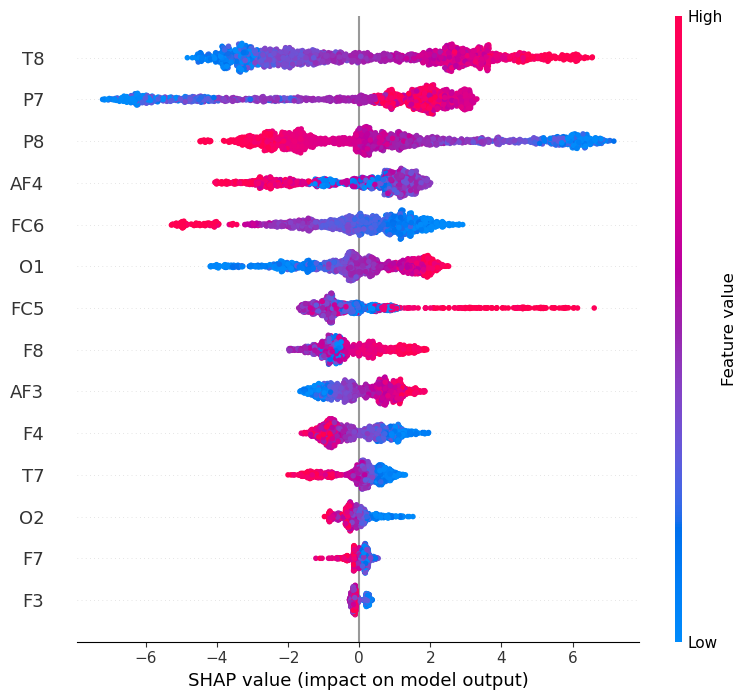

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
Prediction_0,-0.042856,-0.00336,-0.001596,0.048806,0.005860,0.026813,0.040959,-0.024642,-0.008762,0.006895,-0.069937,0.022359,-0.012160,0.027769
Prediction_1,-0.064663,0.01357,0.054074,0.024637,-0.032612,0.046267,-0.045892,0.015810,-0.001734,0.011592,-0.044061,0.051320,-0.054033,0.017117


In [17]:

# Hzごと
# 特徴量と目標変数を抽出する
X = df.drop('State', axis=1)  # 'State'以外の列すべてを特徴量とします
y = df['State']  # 'State'を目標変数とします

# 列名のリストを定義
column_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
#XGBoost
#XGBoost(X, y)

# XGBoostを実行して訓練データと予測値を取得
shap_values, y_train_pred, X_train_df = XGBoost(X, y)

"""
# 予測値をpandas DataFrameに変換
predictions = pd.DataFrame(y_train_pred, columns=['Prediction'])

# 予測値を二値化（0.5を閾値とする）
predictions_binary = predictions['Prediction'].apply(lambda x: 1 if x > 0.5 else 0)

# EEGデータと二値化した予測値を結合
combined_data = pd.concat([X_train_df, predictions_binary], axis=1)

# 相関行列を計算
correlation_matrix = combined_data.corr()

# 'Prediction'とEEGチャネルの相関を表示
print(correlation_matrix['Prediction'])

# 相関行列のヒートマップを描画
sns.heatmap(correlation_matrix, 
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
"""
# 予測値を二値化（0.5を閾値とする）
y_train_pred_binary = [1 if pred > 0.5 else 0 for pred in y_train_pred]

# DataFrameに変換
df_shap = pd.DataFrame(shap_values, columns=column_names)
df_shap['Prediction'] = y_train_pred_binary

# 予測結果ごとにSHAP値を分割
df_shap_0 = df_shap[df_shap['Prediction'] == 0].drop(columns=['Prediction'])
df_shap_1 = df_shap[df_shap['Prediction'] == 1].drop(columns=['Prediction'])

# 各チャンネルについてSHAP値とEEG電圧との相関を計算
correlations_0 = df_shap_0.corrwith(X_train_df.loc[df_shap_0.index.intersection(X_train_df.index)])
correlations_1 = df_shap_1.corrwith(X_train_df.loc[df_shap_1.index.intersection(X_train_df.index)])

correlations_df = pd.DataFrame({
    'Prediction_0': correlations_0,
    'Prediction_1': correlations_1
})

correlations_df.T

In [ ]:
"""
#１秒ごとに分割
# ラベルの作成（5秒閉じ、5秒開け）
labels_close = [0] * 5 *64 
labels_open = [1] * 5 * 64
labels = labels_close + labels_open

#labels = df.iloc[:, -1]

#14chデータ
n_samples_per_second = 4
total_seconds = 10  # 全体の秒数
#total_seconds = 3242  # 全体の秒数

# データとラベルを1秒ごとに分割
#X = np.array([df.iloc[i*n_samples_per_second:(i+1)*n_samples_per_second, :-1].values for i in range(total_seconds)])

X = np.array([df.iloc[i*n_samples_per_second:(i+1)*n_samples_per_second, :-1].values for i in range(total_seconds*64)])
#labels = np.array([stats.mode(y[i*n_samples_per_second:(i+1)*n_samples_per_second])[0][0] for i in range(total_seconds*64)])


# 1秒ごとのデータの平均を取得
X = X.mean(axis=1)

#XGBoost
XGBoost(X, labels)

#plot
#plot_importance(raw, model1)

"""